K Bala Sai Manvitha - CS22B1030

In [48]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

# Load FashionMNIST dataset
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize to [0,1]

# Reshape to add channel dimension (needed for dense layers)
x_train = x_train.reshape(-1, 28 * 28).astype("float32")
x_test = x_test.reshape(-1, 28 * 28).astype("float32")

# Set latent space dimension
latent_dim = 20

# Define Encoder
class Encoder(Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.dense1 = layers.Dense(256, activation="tanh")
        self.dense2 = layers.Dense(2 * latent_dim)  # Mean and log variance

    def call(self, inputs):
        x = self.dense1(inputs)
        z_params = self.dense2(x)
        z_mean, z_log_var = z_params[:, :latent_dim], z_params[:, latent_dim:]
        return z_mean, z_log_var

# Define Reparameterization Trick
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        epsilon = tf.keras.backend.random_normal(shape=(batch, latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Define Decoder
class Decoder(Model):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.dense1 = layers.Dense(256, activation="tanh")
        self.dense2 = layers.Dense(28 * 28, activation="sigmoid")

    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

# Define Variational Autoencoder (VAE)
class VAE(Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.sampling = Sampling()
        self.decoder = Decoder(latent_dim)

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling([z_mean, z_log_var])
        reconstructed = self.decoder(z)

        # Compute KL loss
        kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)

        return reconstructed

# Instantiate and compile the VAE
vae = VAE(latent_dim)
vae.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy())

# Train the model
vae.fit(x_train, x_train, epochs=10, batch_size=128, validation_data=(x_test, x_test))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.5891 - val_loss: 0.4775
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.4759 - val_loss: 0.4750
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.4730 - val_loss: 0.4738
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.4719 - val_loss: 0.4729
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.4699 - val_loss: 0.4717
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.4685 - val_loss: 0.4681
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.4669 - val_loss: 0.4679
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4661 - val_loss: 0.4697
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.4657 - val_loss: 0.4689
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.4662 - val_loss: 0.4676


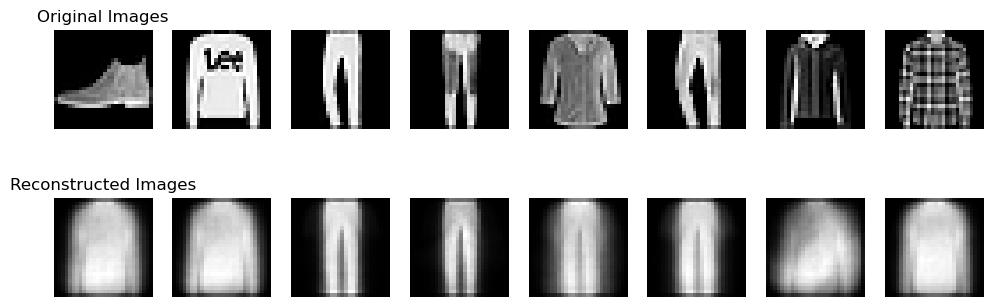

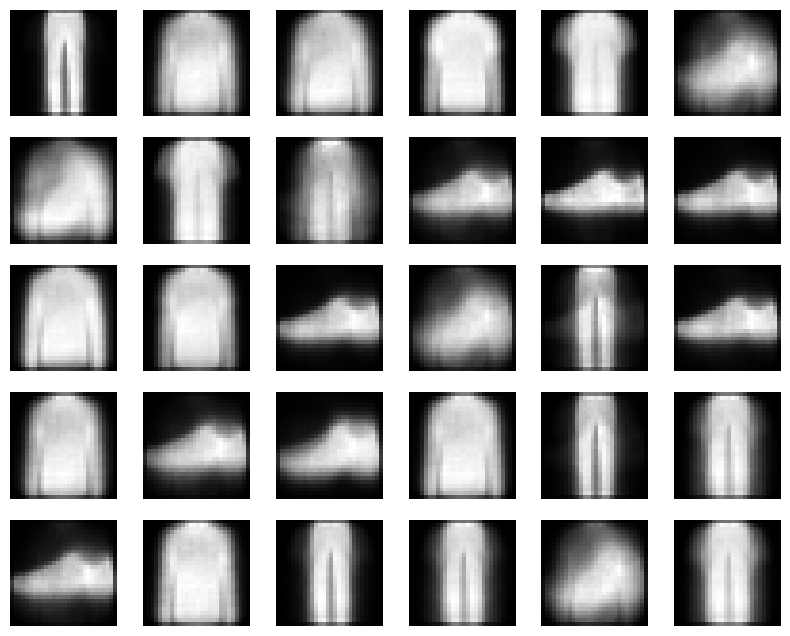

In [49]:
# Generate reconstructed images
vae.eval = True
original_images = x_test[:8]  # Select some test images (already NumPy arrays)
reconstructed_images = vae(original_images)  # Output is a TensorFlow tensor

# Convert only TensorFlow tensor to NumPy
reconstructed_images = reconstructed_images.numpy()

# Function to plot original and generated images
def compare_images(original, generated, num_images=8):
    fig, axes = plt.subplots(2, num_images, figsize=(12, 4))
    
    for i in range(num_images):
        axes[0, i].imshow(original[i].reshape(28, 28), cmap="gray")
        axes[0, i].axis("off")

        axes[1, i].imshow(generated[i].reshape(28, 28), cmap="gray")
        axes[1, i].axis("off")

    axes[0, 0].set_title("Original Images", fontsize=12)
    axes[1, 0].set_title("Reconstructed Images", fontsize=12)
    plt.show()

# Show original vs reconstructed images
compare_images(original_images, reconstructed_images)

# Generate 30 new samples
num_samples = 30
random_latent_vectors = np.random.normal(size=(num_samples, latent_dim))
generated_samples = vae.decoder(random_latent_vectors).numpy()

# Function to plot generated images
def plot_images(images, n_rows=5, n_cols=6):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.show()

# Plot generated samples
plot_images(generated_samples)